# Xây dựng mô hình nhận diện khẩu trang sử dụng MobileNetV2 và transfer learning

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


### Khởi tạo tốc độ học ban đầu, số epochs và kích thước batch

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [20]:
# Đường dẫn đến thư mục chứa dữ liệu và các nhãn


#Dataset link: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
DIRECTORY = 'dataset'
CATEGORIES = ["with_mask", "without_mask"]

### Khởi tạo dataset, label và tiền xử lý theo MobileNetV2

In [21]:

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        # Tải hình ảnh và thay đổi kích thước về (224, 224) (đúng kích thước đầu vào của MobileNetV2)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        # Tiền xử lý hình ảnh theo yêu cầu của MobileNetV2
        image = preprocess_input(image)

        # Thêm hình ảnh và nhãn tương ứng vào danh sách data và labels
        data.append(image)
        labels.append(category)


C:\Users\ntt60\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


: 

In [7]:
# Mã hóa one-hot trên nhãn
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Chuyển đổi data và labels thành các mảng numpy
data = np.array(data, dtype="float32")
labels = np.array(labels)

# data split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)


### Thực hiện tăng cường dữ liệu

In [8]:

aug = ImageDataGenerator(
    rotation_range=20,          # Góc xoay tối đa của hình ảnh
    zoom_range=0.15,            # Phạm vi thu phóng ngẫu nhiên
    width_shift_range=0.2,      # Phạm vi dịch ngang ngẫu nhiên
    height_shift_range=0.2,     # Phạm vi dịch dọc ngẫu nhiên
    shear_range=0.15,           # Phạm vi cắt ngẫu nhiên
    horizontal_flip=True,       # Lật ngang ngẫu nhiên
    fill_mode="nearest"         #  sử dụng chiến lược "nearest" để điền giá trị gần nhất cho các pixel mới tạo ra.
)


In [9]:
# Tải mô hình MobileNetV2 đã được huấn luyện trên ImageNet
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

### Xây dựng phần đầu của mô hình

In [10]:
headModel = baseModel.output

# Thêm lớp trung bình của các tính năng (AveragePooling2D)
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)

# Làm phẳng output của lớp Average
headModel = Flatten(name="flatten")(headModel)

# Thêm một lớp fully connected với 128 đơn vị ẩn và hàm kích hoạt relu
headModel = Dense(128, activation="relu")(headModel)

# Áp dụng Dropout với tỷ lệ 0.5 để tránh overfitting
headModel = Dropout(0.5)(headModel)

# Thêm lớp fully connected cuối cùng với 2 đơn vị đầu ra và hàm kích hoạt softmax cho việc phân loại thành 2 lớp
headModel = Dense(2, activation="softmax")(headModel)


## Tạo ra mô hình hoàn chỉnh

In [11]:

model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
""" Lặp qua tất cả các lớp trong base model và đóng băng chúng
 để chúng sẽ *không* được cập nhật trong quá trình huấn luyện ban đầu để giữ lại các trọng số của các lớp 
đã được huấn luyện trước trên tập dữ liệu ImageNet và tránh việc ghi đè lên chúng trong quá trình huấn luyện mới."""
for layer in baseModel.layers:
    layer.trainable = False

## Biên dịch mô hình

In [13]:

print("[INFO] compiling model...")
from tensorflow.keras.optimizers import legacy
opt = legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


[INFO] compiling model...


C:\Users\ntt60\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Huấn luyện phần đầu của mô hình

In [14]:

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] training head...
Epoch 1/20
95/95 [==============================] - 56s 556ms/step - loss: 0.4031 - accuracy: 0.8520 - val_loss: 0.1516 - val_accuracy: 0.9857
Epoch 2/20
95/95 [==============================] - 54s 563ms/step - loss: 0.1515 - accuracy: 0.9631 - val_loss: 0.0807 - val_accuracy: 0.9896
Epoch 3/20
95/95 [==============================] - 52s 550ms/step - loss: 0.0976 - accuracy: 0.9759 - val_loss: 0.0573 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 50s 521ms/step - loss: 0.0795 - accuracy: 0.9789 - val_loss: 0.0477 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 50s 526ms/step - loss: 0.0634 - accuracy: 0.9825 - val_loss: 0.0426 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 53s 555ms/step - loss: 0.0571 - accuracy: 0.9835 - val_loss: 0.0375 - val_accuracy: 0.9948
Epoch 7/20
95/95 [==============================] - 53s 559ms/step - loss: 0.0600 - accuracy: 0.9838 - val_loss: 0.037

##  Thực hiện đánh giá hiệu suất của mô hình trên tập dữ liệu kiểm tra

In [15]:

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...
24/24 [==============================] - 10s 407ms/step


In [16]:
# Đối với mỗi hình ảnh trong tập dữ liệu kiểm tra, chúng ta cần tìm chỉ số của nhãn có xác suất dự đoán cao nhất
# thực hiện việc tìm chỉ số của nhãn có xác suất dự đoán cao nhất cho mỗi hình ảnh trong tập dữ liệu kiểm tra
predIdxs = np.argmax(predIdxs, axis=1)


In [17]:
# Hiển thị báo cáo phân loại
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [18]:
# Lưu mô hình
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


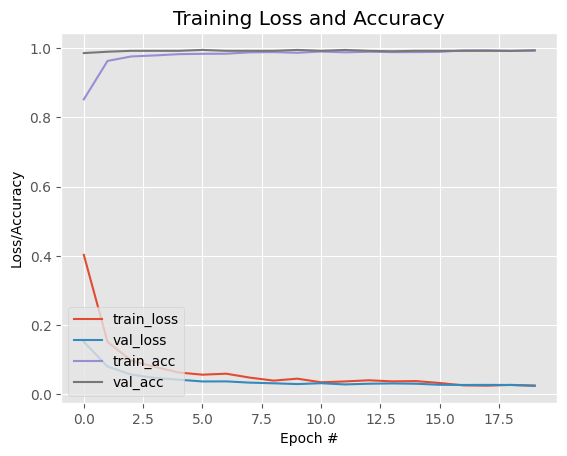

In [19]:
# Vẽ biểu đồ về sự thay đổi của loss và accuracy trong quá trình huấn luyện
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
